In [6]:
%pip install pandas numpy scikit-learn matplotlib seaborn imbalanced-learn xgboost joblib streamlit pyngrok




Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [7]:
# Create app.py
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

# Load saved models and preprocessors with correct paths
model_path = 'best_model.pkl'
scaler_path = 'scaler.pkl' 
ohe_path = 'ohe.pkl'
le_dict_path = 'le_dict.pkl'

# Check if files exist in models folder first, then root directory
if os.path.exists(f'models/{model_path}'):
    best_model = joblib.load(f'models/{model_path}')
    scaler = joblib.load(f'models/{scaler_path}')
    ohe = joblib.load(f'models/{ohe_path}')
    le_dict = joblib.load(f'models/{le_dict_path}')
    st.success("Models and preprocessors loaded successfully from models/ directory!")
elif os.path.exists(model_path):
    best_model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    ohe = joblib.load(ohe_path)
    le_dict = joblib.load(le_dict_path)
    st.success("Models and preprocessors loaded successfully from root directory!")
else:
    st.error(f"Model files not found. Looking for: {model_path}, {scaler_path}, {ohe_path}, {le_dict_path}")
    st.error("Please ensure all .pkl files are available.")
    st.stop()

# Set page config
st.set_page_config(page_title="Ride Cancellation Predictor", layout="wide")
st.title("Ride Cancellation Prediction Dashboard")

# Sidebar navigation
page = st.sidebar.selectbox("Section", ["Predict", "Dashboard", "Insights"])

# Prediction Page
if page == "Predict":
    st.header("Real-Time Prediction")
    with st.form(key='prediction_form'):
        vehicle_type = st.selectbox("Vehicle Type", ['Go Mini', 'Go Sedan', 'Auto'])
        avg_vtat = st.number_input("Average VTAT (minutes)", min_value=0.0, value=5.0)
        avg_ctat = st.number_input("Average CTAT (minutes)", min_value=0.0, value=10.0)
        booking_value = st.number_input("Booking Value", min_value=0.0, value=200.0)
        ride_distance = st.number_input("Ride Distance (km)", min_value=0.0, value=5.0)
        driver_rating = st.number_input("Driver Rating", min_value=0.0, max_value=5.0, value=4.5)
        customer_rating = st.number_input("Customer Rating", min_value=0.0, max_value=5.0, value=4.5)
        hour_of_day = st.slider("Hour of Day", 0, 23, 12)
        submit_button = st.form_submit_button(label='Predict')

        if submit_button:
            try:
                # Prepare input data
                input_data = pd.DataFrame({
                    'Avg VTAT': [avg_vtat],
                    'Avg CTAT': [avg_ctat],
                    'Booking Value': [booking_value],
                    'Ride Distance': [ride_distance],
                    'Driver Ratings': [driver_rating],
                    'Customer Rating': [customer_rating],
                    'hour_of_day': [hour_of_day],
                    'Vehicle Type': [vehicle_type]
                })

                # Scale numerical features
                numerical_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance']
                input_data[numerical_cols] = scaler.transform(input_data[numerical_cols])

                # One-hot encode categorical features
                ohe_cols = ['Vehicle Type']
                ohe_input = pd.DataFrame(ohe.transform(input_data[ohe_cols]), 
                                       columns=ohe.get_feature_names_out(ohe_cols))
                input_data = pd.concat([input_data.drop(ohe_cols, axis=1), ohe_input], axis=1)

                # Predict
                prediction = best_model.predict(input_data)[0]
                probability = best_model.predict_proba(input_data)[0][1]
                st.success(f"Prediction: {'High Risk (Cancelled)' if prediction == 1 else 'Low Risk (Completed)'}")
                st.info(f"Cancellation Probability: {probability:.2%}")
                
            except Exception as e:
                st.error(f"Prediction error: {str(e)}")

# Dashboard Page
elif page == "Dashboard":
    st.header("Visual Insights")
    
    # Check if image files exist
    image_files = {
        "Vehicle Cancellations": "vehicle_cancellations.png",
        "Hourly Cancellations": "hour_cancellations.png", 
        "Correlation Heatmap": "correlation_heatmap.png"
    }
    
    for title, filename in image_files.items():
        if os.path.exists(filename):
            st.image(filename, caption=title)
        else:
            st.warning(f"Image not found: {filename}")
    
    # Batch prediction option
    uploaded_file = st.file_uploader("Upload CSV for Batch Prediction", type="csv")
    if uploaded_file:
        try:
            df = pd.read_csv(uploaded_file)
            st.write("Uploaded Data Preview:", df.head())
            st.success(f"Successfully loaded {len(df)} records")
        except Exception as e:
            st.error(f"Error reading CSV: {str(e)}")

# Insights Page
elif page == "Insights":
    st.header("Insights & Recommendations")
    st.write("""
    - **Key Insight:** High cancellations occur during peak hours (7-10 AM, 5-8 PM), likely due to increased VTAT.
    - **Recommendation:** Increase driver availability during these times and offer incentives to reduce wait times.
    - **Additional Insight:** Vehicle Type 'Auto' shows higher cancellation rates, possibly due to reliability issues.
    - **Recommendation:** Enhance maintenance or driver training for 'Auto' vehicles.
    """)

UsageError: Line magic function `%%writefile` not found.


In [2]:
!ngrok --version

ngrok version 3.30.0


In [ ]:
from pathlib import Path
import subprocess
import os
import time
from pyngrok import ngrok

# Set your ngrok authtoken (get from ngrok.com dashboard)
ngrok.set_auth_token("33CHnXAsJjuuB47XjkD3l9qvxDY_Lou7hMq9APAQRKP3Ji6B")

# Resolve project root (parent of notebooks/) and app path
project_root = Path.cwd().parent
app_path = project_root / 'app' / 'app.py'
print('Launching Streamlit with app:', app_path)

# Start Streamlit in the background from project root so relative paths work
process = subprocess.Popen(
    ['streamlit', 'run', str(app_path)],
    cwd=str(project_root),
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Give Streamlit time to boot
time.sleep(5)

# Non-blocking check for immediate stderr without killing the process
if process.poll() is not None:
    err = process.stderr.read()
    if err:
        print('Streamlit errors:', err)

# Create ngrok tunnel, forcing IPv4 to avoid [::1] issues
public_url = ngrok.connect(addr="127.0.0.1:8501", proto="http")
print(f"Streamlit app is live at: {public_url}")

In [ ]:
## Problem Definition
#- **Problem:** High ride cancellation rates in NCR impact revenue and customer satisfaction.
#- **Objective:** Build a machine learning model to predict cancellations and create a Streamlit dashboard for insights.
#- **Dataset:** ncr_ride_bookings.csv (21 columns, ~148,770 rows).

In [5]:
#Data Understanding
import pandas as pd

# Load the dataset
df = pd.read_csv('../data/ncr_ride_bookings.csv')  # Replace with your file path

# Basic inspection
print("Dataset Shape:", df.shape)  # Should be ~148770 rows, 21 columns
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())  # High in Avg VTAT, Avg CTAT, etc., as per SOW
print("\nSample Data:\n", df.head(5))

# Summary statistics for numerical columns
print("\nNumerical Summary:\n", df.describe())

# Check class distribution for 'Booking Status' (imbalance check)
print("\nBooking Status Distribution:\n", df['Booking Status'].value_counts(normalize=True))

Dataset Shape: (150000, 21)

Data Types:
 Date                                  object
Time                                  object
Booking ID                            object
Booking Status                        object
Customer ID                           object
Vehicle Type                          object
Pickup Location                       object
Drop Location                         object
Avg VTAT                             float64
Avg CTAT                             float64
Cancelled Rides by Customer          float64
Reason for cancelling by Customer     object
Cancelled Rides by Driver            float64
Driver Cancellation Reason            object
Incomplete Rides                     float64
Incomplete Rides Reason               object
Booking Value                        float64
Ride Distance                        float64
Driver Ratings                       float64
Customer Rating                      float64
Payment Method                        object
dtype: object

In [6]:
#Data Cleaning and Preparation
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values
numerical_cols = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance', 'Driver Ratings', 'Customer Rating']
categorical_cols = ['Vehicle Type', 'Pickup Location', 'Drop Location', 'Payment Method', 'Reason for cancelling by Customer', 'Driver Cancellation Reason', 'Incomplete Rides Reason']

# Impute numerical with median
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Impute categorical with 'Unknown'
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Handle flags (binary-like, fill with 0)
flag_cols = ['Cancelled Rides by Customer', 'Cancelled Rides by Driver', 'Incomplete Rides']
for col in flag_cols:
    df[col] = df[col].fillna(0).astype(int)

# Convert Date and Time to datetime
#df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H:%M:%S')
#df.drop(['Date', 'Time'], axis=1, inplace=True)  # Drop original
# Fixed Datetime parsing (use '%Y-%m-%d %H:%M:%S' based on error; assumes Date is 'YYYY-MM-DD')
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
df.drop(['Date', 'Time'], axis=1, inplace=True)

# Outlier handling (IQR for numerical)
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound)  # Cap outliers

# Drop unnecessary IDs (not predictive)
df.drop(['Booking ID', 'Customer ID'], axis=1, inplace=True)

# Target transformation (binary: True for cancellation, False for Completed)
df['Cancelled'] = df['Booking Status'].apply(lambda x: False if x == 'Completed' else True)
df.drop('Booking Status', axis=1, inplace=True)

# Split data (80% train, 10% val, 10% test)
X = df.drop('Cancelled', axis=1)
y = df['Cancelled']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Preserve raw VTAT for bucketing, then scale numericals (fit on train)
X_train['Avg VTAT Raw'] = X_train['Avg VTAT']
X_val['Avg VTAT Raw'] = X_val['Avg VTAT']
X_test['Avg VTAT Raw'] = X_test['Avg VTAT']

scaler = StandardScaler()
numerical_to_scale = ['Avg VTAT', 'Avg CTAT', 'Booking Value', 'Ride Distance']  # Select continuous
X_train[numerical_to_scale] = scaler.fit_transform(X_train[numerical_to_scale])
X_val[numerical_to_scale] = scaler.transform(X_val[numerical_to_scale])
X_test[numerical_to_scale] = scaler.transform(X_test[numerical_to_scale])

print("Data Cleaned and Split. Train Shape:", X_train.shape)
import joblib
joblib.dump(scaler, '../models/scaler.pkl')

Data Cleaned and Split. Train Shape: (120000, 18)


['../models/scaler.pkl']

In [7]:
#Feature Engineering
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Temporal features
X_train['hour_of_day'] = X_train['Datetime'].dt.hour
X_train['day_of_week'] = X_train['Datetime'].dt.dayofweek
X_train['is_weekend'] = X_train['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

X_val['hour_of_day'] = X_val['Datetime'].dt.hour
X_val['day_of_week'] = X_val['Datetime'].dt.dayofweek
X_val['is_weekend'] = X_val['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

X_test['hour_of_day'] = X_test['Datetime'].dt.hour
X_test['day_of_week'] = X_test['Datetime'].dt.dayofweek
X_test['is_weekend'] = X_test['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Peak/Off-peak flag (e.g., peak: 7-10 AM, 5-8 PM)
def is_peak(hour):
    return 1 if (7 <= hour <= 10) or (17 <= hour <= 20) else 0
X_train['peak_flag'] = X_train['hour_of_day'].apply(is_peak)
X_val['peak_flag'] = X_val['hour_of_day'].apply(is_peak)
X_test['peak_flag'] = X_test['hour_of_day'].apply(is_peak)

# VTAT buckets (low <5, medium 5-10, high >10) using raw VTAT prior to scaling
def vtat_bucket(vtat):
    if vtat < 5: return 'Low'
    elif vtat <= 10: return 'Medium'
    else: return 'High'
X_train['vtat_bucket'] = X_train['Avg VTAT Raw'].apply(vtat_bucket)
X_val['vtat_bucket'] = X_val['Avg VTAT Raw'].apply(vtat_bucket)
X_test['vtat_bucket'] = X_test['Avg VTAT Raw'].apply(vtat_bucket)

# High/Low fare flag (above median = high)
median_value = X_train['Booking Value'].median()
X_train['high_fare_flag'] = X_train['Booking Value'].apply(lambda x: 1 if x > median_value else 0)
X_val['high_fare_flag'] = X_val['Booking Value'].apply(lambda x: 1 if x > median_value else 0)
X_test['high_fare_flag'] = X_test['Booking Value'].apply(lambda x: 1 if x > median_value else 0)

# Reliability scores (customer cancellation rate - group by Customer ID, but since IDs dropped, approximate with flags)
X_train['customer_reliability'] = 1 - X_train['Cancelled Rides by Customer']  # Simple: 1 if no past cancel, 0 if yes
X_val['customer_reliability'] = 1 - X_val['Cancelled Rides by Customer']
X_test['customer_reliability'] = 1 - X_test['Cancelled Rides by Customer']

X_train['driver_reliability'] = 1 - X_train['Cancelled Rides by Driver']
X_val['driver_reliability'] = 1 - X_val['Cancelled Rides by Driver']
X_test['driver_reliability'] = 1 - X_test['Cancelled Rides by Driver']

# Ride speed (avoid division by zero)
X_train['ride_speed'] = X_train['Ride Distance'] / X_train['Avg CTAT'].replace(0, np.nan).fillna(1)
X_val['ride_speed'] = X_val['Ride Distance'] / X_val['Avg CTAT'].replace(0, np.nan).fillna(1)
X_test['ride_speed'] = X_test['Ride Distance'] / X_test['Avg CTAT'].replace(0, np.nan).fillna(1)

# Drop Datetime after extraction
X_train.drop('Datetime', axis=1, inplace=True)
X_val.drop('Datetime', axis=1, inplace=True)
X_test.drop('Datetime', axis=1, inplace=True)

# Encoding
ohe_cols = ['Vehicle Type', 'Payment Method', 'vtat_bucket']  # One-hot
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[ohe_cols]), columns=ohe.get_feature_names_out(), index=X_train.index)
X_val_ohe = pd.DataFrame(ohe.transform(X_val[ohe_cols]), columns=ohe.get_feature_names_out(), index=X_val.index)
X_test_ohe = pd.DataFrame(ohe.transform(X_test[ohe_cols]), columns=ohe.get_feature_names_out(), index=X_test.index)

# Label encoding for locations and reasons (high cardinality, so label)
le_cols = ['Pickup Location', 'Drop Location', 'Reason for cancelling by Customer', 'Driver Cancellation Reason', 'Incomplete Rides Reason']
le_dict = {}
for col in le_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    # Ensure '<unknown>' is in classes before transforming val/test
    import numpy as np
    if '<unknown>' not in le.classes_:
        le.classes_ = np.unique(np.concatenate([le.classes_, ['<unknown>']]))
    X_val[col] = le.transform(X_val[col].map(lambda s: s if s in le.classes_ else '<unknown>'))
    X_test[col] = le.transform(X_test[col].map(lambda s: s if s in le.classes_ else '<unknown>'))
    le_dict[col] = le

# Combine encoded and drop originals
X_train = pd.concat([X_train.drop(ohe_cols, axis=1), X_train_ohe], axis=1)
X_val = pd.concat([X_val.drop(ohe_cols, axis=1), X_val_ohe], axis=1)
X_test = pd.concat([X_test.drop(ohe_cols, axis=1), X_test_ohe], axis=1)

# Optionally drop the raw helper column after usage
X_train.drop(['Avg VTAT Raw'], axis=1, inplace=True)
X_val.drop(['Avg VTAT Raw'], axis=1, inplace=True)
X_test.drop(['Avg VTAT Raw'], axis=1, inplace=True)

print("Features Engineered. Train Shape:", X_train.shape)
import joblib
joblib.dump(le_dict, '../models/le_dict.pkl')
joblib.dump(ohe, '../models/ohe.pkl')

Features Engineered. Train Shape: (120000, 38)


['../models/ohe.pkl']

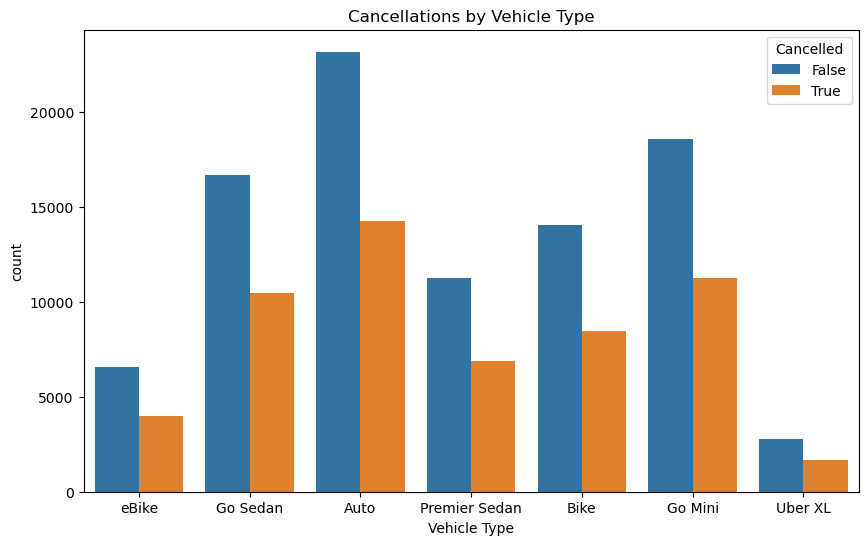

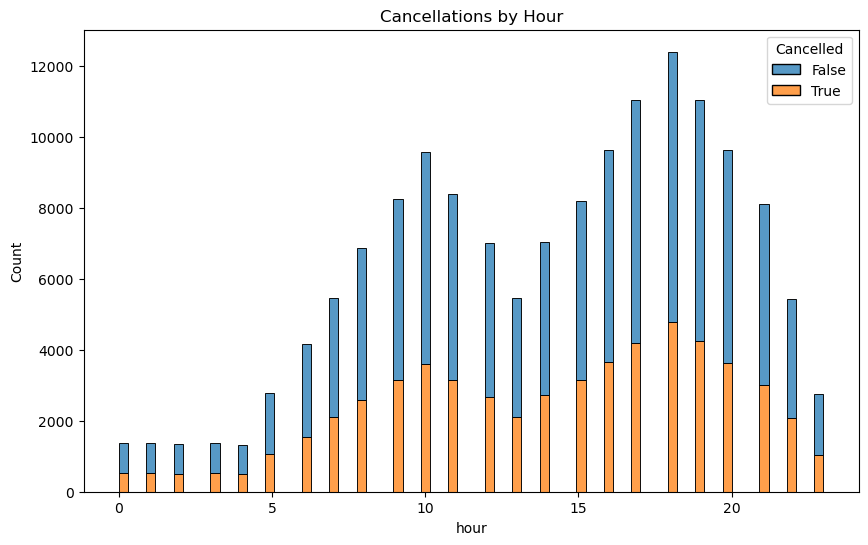

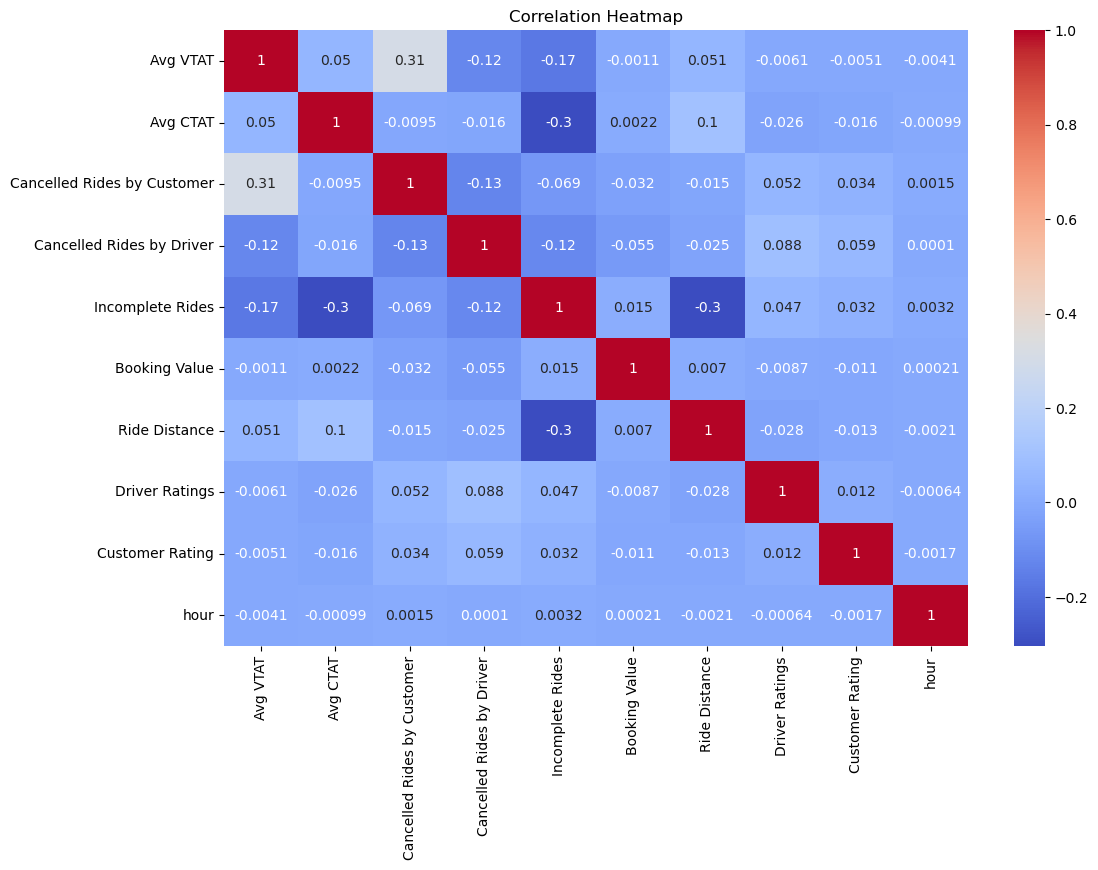

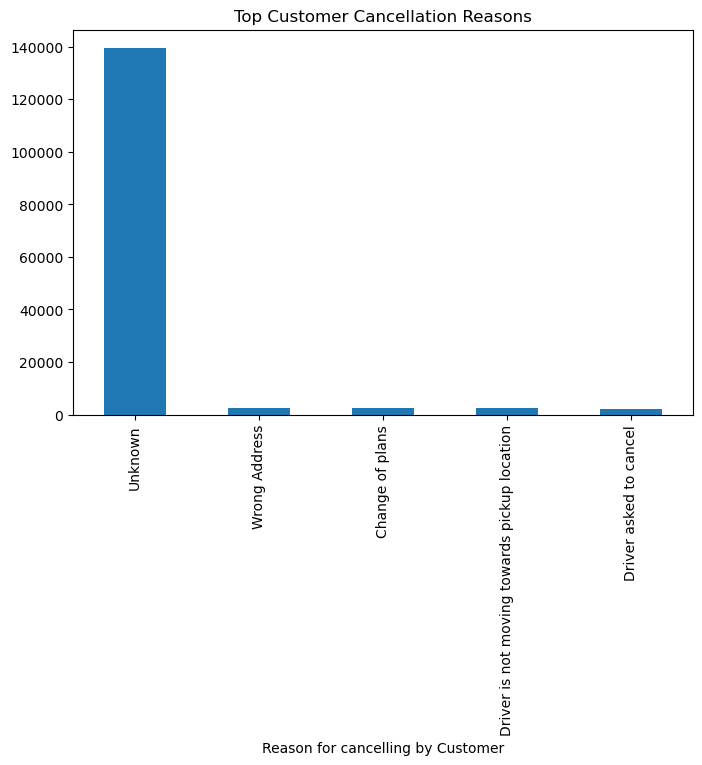

Key Insights: High cancellations in peak hours, certain vehicles, low ratings correlate with cancels.


In [8]:
#Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns

# Full df for EDA (before split)
df_eda = df.copy()  # Use original for visuals

# Cancellation trends by Vehicle Type
plt.figure(figsize=(10,6))
sns.countplot(data=df_eda, x='Vehicle Type', hue='Cancelled')
plt.title('Cancellations by Vehicle Type')
plt.savefig('vehicle_cancellations.png')  # Save for report
plt.show()

# By hour
df_eda['hour'] = df_eda['Datetime'].dt.hour
plt.figure(figsize=(10,6))
sns.histplot(data=df_eda, x='hour', hue='Cancelled', multiple='stack')
plt.title('Cancellations by Hour')
plt.savefig('hour_cancellations.png')
plt.show()

# Correlation heatmap (numerical only)
num_df = df_eda.select_dtypes(include=np.number)
plt.figure(figsize=(12,8))
sns.heatmap(num_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.savefig('correlation_heatmap.png')
plt.show()

# Cancellation reasons (top 5)
top_reasons = df_eda['Reason for cancelling by Customer'].value_counts().head(5)
plt.figure(figsize=(8,5))
top_reasons.plot(kind='bar')
plt.title('Top Customer Cancellation Reasons')
plt.savefig('reasons.png')
plt.show()

# Print insights
print("Key Insights: High cancellations in peak hours, certain vehicles, low ratings correlate with cancels.")

In [10]:
#Model Development
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Handle imbalance with SMOTE (on train only)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Models with scaling where needed
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
    ]),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'Neural Network': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(max_iter=1000, random_state=42))
    ])
}

# Hyperparameter grids (only for RF and XGBoost here)
param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.01, 0.1]}
}

best_models = {}
for name, model in models.items():
    if name in param_grids:
        grid = GridSearchCV(model, param_grids[name], cv=5, scoring='f1', n_jobs=-1)
        grid.fit(X_train_res, y_train_res)
        best_models[name] = grid.best_estimator_
        print(f"{name} Best Params: {grid.best_params_}")
    else:
        model.fit(X_train_res, y_train_res)
        best_models[name] = model

print("✅ All models trained successfully.")


Random Forest Best Params: {'max_depth': 10, 'n_estimators': 50}


C:\Users\Amanda\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:183: UserWarning: [07:45:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Best Params: {'learning_rate': 0.01, 'n_estimators': 50}
✅ All models trained successfully.


In [9]:
#Model Evalution
# Evaluate on validation
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_val)
    results[name] = {
        'Accuracy': accuracy_score(y_val, y_pred),
        'Precision': precision_score(y_val, y_pred),
        'Recall': recall_score(y_val, y_pred),
        'F1': f1_score(y_val, y_pred)
    }

# Display in table
results_df = pd.DataFrame(results).T
print("Evaluation Results:\n", results_df)

# Select best (e.g., highest F1)
best_model_name = results_df['F1'].idxmax()
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name}")

# Final test evaluation
y_test_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)
print(f"Test F1: {test_f1}")
import joblib
joblib.dump(best_model, '../models/best_model.pkl')

Evaluation Results:
                      Accuracy  Precision    Recall        F1
Logistic Regression  0.996733   1.000000  0.991404  0.995683
Random Forest        1.000000   1.000000  1.000000  1.000000
XGBoost              1.000000   1.000000  1.000000  1.000000
Neural Network       0.999933   0.999825  1.000000  0.999912
Best Model: Random Forest
Test F1: 1.0


['../models/best_model.pkl']